In [1]:
import gc 
gc.collect()

0

In [7]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import pandas as pd


def entrenar_modelo_por_finde(path_modelado, test):
    df = pd.read_csv(path_modelado)
    test = pd.read_csv(test)
    df.dropna(inplace=True)
    df = df[df["duracion_recorrido"] > 1].copy()

    target = "N_arribos_intervalo"
    cols_a_excluir = [
        "N_arribos_intervalo",
        "N_salidas_intervalo",         
        "id_recorrido",
        "id_estacion_destino",
        "barrio_destino",
        "zona_destino_cluster",
        "cantidad_estaciones_cercanas_destino",
        "año_destino", "mes_destino", "dia_destino",
        "hora_destino", "minuto_destino", "segundo_destino",
        "duracion_recorrido",
        "fecha_intervalo", "esatacion_referencia"
    ]

    # SPLIT TEMPORAL: entrenamiento con todo hasta abril 2024, test desde mayo 2024
    df_train = df
    df_val = test

    modelos = {}
    y_val_preds = pd.Series(index=df_val.index, dtype=float)

    for es_finde_val in [0, 1]:
        print(f"\nEntrenando modelo para es_finde = {es_finde_val}...")

        df_train_sub = df_train[df_train["es_finde"] == es_finde_val]
        df_val_sub = df_val[df_val["es_finde"] == es_finde_val]

        X_train = df_train_sub.drop(columns=cols_a_excluir + [target])
        y_train = df_train_sub[target]

        X_val = df_val_sub.drop(columns=cols_a_excluir + [target])
        y_val = df_val_sub[target]

        modelo = XGBRegressor(
            n_estimators=800,
            max_depth=15,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            objective="count:poisson",
            random_state=42,
            n_jobs=-1
        )

        modelo.fit(X_train, y_train)
        modelos[es_finde_val] = modelo

        y_pred = modelo.predict(X_val)
        y_val_preds.loc[df_val_sub.index] = y_pred

    # Evaluación final
    print("\n=== MÉTRICAS VALIDACIÓN GLOBAL ===")
    y_val = df_val[target]
    print("MAE:", mean_absolute_error(y_val, y_val_preds))
    print("R²:", r2_score(y_val, y_val_preds))

    return modelos, df_val, y_val, y_val_preds, X_train

modelos_finde, df_val_finde, y_val_finde, y_val_preds_finde, X_train_finde = entrenar_modelo_por_finde("data/modelado/ds_modelado_ref.csv", "data/modelado/ds_modelado_test_ref.csv")



MemoryError: Unable to allocate 4.53 GiB for an array with shape (47, 12947283) and data type float64


=== FEATURES ORDENADAS POR IMPORTANCIA (es_finde = 0) ===
               feature  importancia
57      N_ARRIBOS_LAG1     0.510540
59      N_ARRIBOS_LAG2     0.204777
63      N_ARRIBOS_LAG4     0.033352
61      N_ARRIBOS_LAG3     0.027139
65      N_ARRIBOS_LAG5     0.021101
..                 ...          ...
1           id_usuario     0.001351
4           dia_semana     0.001242
2     modelo_bicicleta     0.001148
13  usuario_registrado     0.001089
5             es_finde     0.000000

[69 rows x 2 columns]


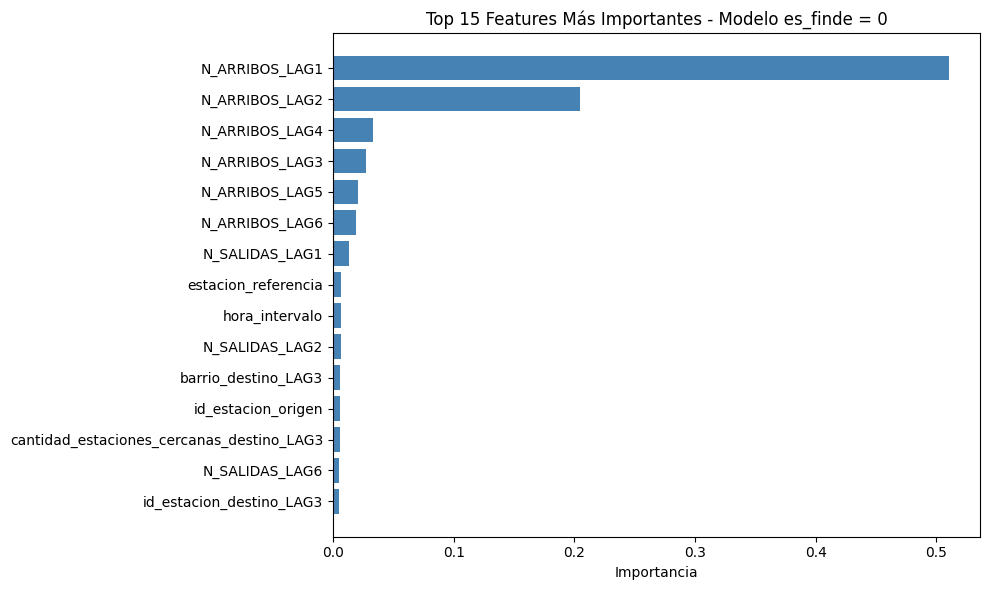


=== FEATURES ORDENADAS POR IMPORTANCIA (es_finde = 1) ===
               feature  importancia
57      N_ARRIBOS_LAG1     0.485612
59      N_ARRIBOS_LAG2     0.263950
63      N_ARRIBOS_LAG4     0.033865
61      N_ARRIBOS_LAG3     0.032907
58      N_SALIDAS_LAG1     0.012490
..                 ...          ...
1           id_usuario     0.001415
6    estacion_del_anio     0.001290
4           dia_semana     0.001260
13  usuario_registrado     0.001073
5             es_finde     0.000000

[69 rows x 2 columns]


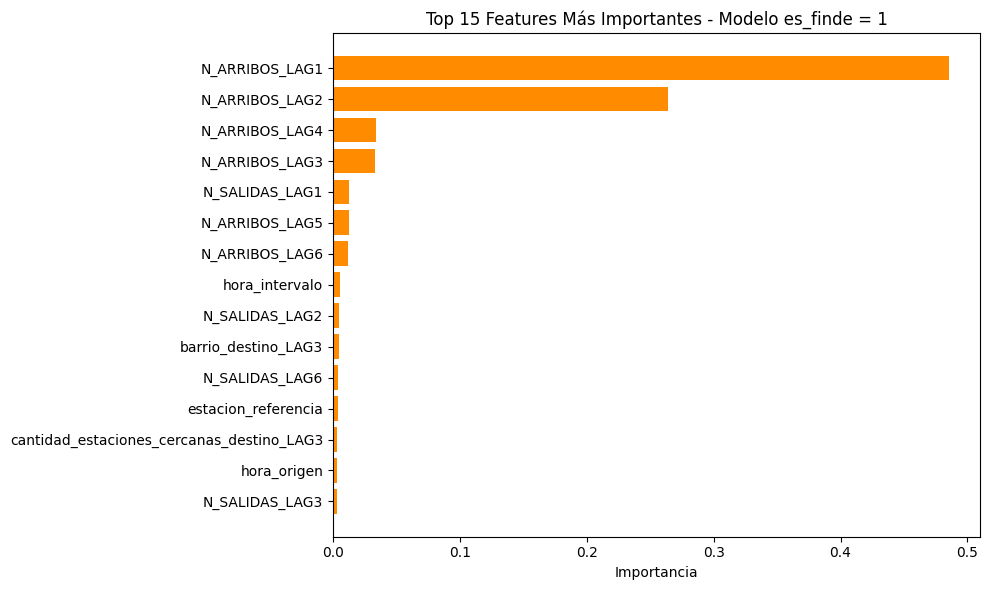

In [6]:
import matplotlib.pyplot as plt
import pandas as pd


def graficar_importancias(modelo, X_train, es_finde_val):
    importancias = modelo.feature_importances_
    features = X_train.columns

    df_importancias = pd.DataFrame({
        "feature": features,
        "importancia": importancias
    }).sort_values(by="importancia", ascending=False)

    print(f"\n=== FEATURES ORDENADAS POR IMPORTANCIA (es_finde = {es_finde_val}) ===")
    print(df_importancias)

    # Gráfico de las 15 más importantes
    top_n = 15
    plt.figure(figsize=(10, 6))
    plt.barh(df_importancias["feature"].iloc[:top_n][::-1], 
             df_importancias["importancia"].iloc[:top_n][::-1], 
             color="darkorange" if es_finde_val else "steelblue")
    plt.xlabel("Importancia")
    plt.title(f"Top {top_n} Features Más Importantes - Modelo es_finde = {es_finde_val}")
    plt.tight_layout()
    plt.show()

for es_finde_val in [0, 1]:
    modelo = modelos_finde[es_finde_val]
    graficar_importancias(modelo, X_train_finde, es_finde_val)
